# Artificial Neural Networks <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

The key idea behind artificial neural networks (ANNs) is inspiration from the brain's architecture. ANNs have become quite different from their biological counterpart over time, and are at the very core of Deep Learning. They are versatile, powerful, and scalable, making them ideal to tackle large and highly complex Machine Learning tasks such as classifying billions of images, powering speech recognition services, and recommending the best videos to watch.

In this chapter we will introduce ANN architecture and present Multi-Layer Perceptrons (MLPs)and implement using TensorFlow for classification.

* [1. Background <a class="anchor" id="background"></a>](#1.-Background-<a-class="anchor"-id="background"></a>)
* [From Biological to Artificial Neurons](#From-Biological-to-Artificial-Neurons)
    * [Biological Neurons](#Biological-Neurons)
    * [Logical Computations with Neurons](#Logical-Computations-with-Neurons)
    * [The Perceptron](#The-Perceptron)
	* [Multi-Layer Perceptron and Backpropagation](#Multi-Layer-Perceptron-and-Backpropagation)
	* [Activation Functions](#Activation-Functions)
* [2. Training an MLP with TensorFlow API <a class="anchor" id="mlp"></a>](#2.-Training-an-MLP-with-TensorFlow-API-<a-class="anchor"-id="mlp"></a>)
* [3. Training a DNN with Plain TensorFlow <a class="anchor" id="dnn"></a>](#3.-Training-a-DNN-with-Plain-TensorFlow-<a-class="anchor"-id="dnn"></a>)
	* [Construction Phase](#Construction-Phase)
	* [Execution Phase](#Execution-Phase)
	* [Using the Neural Network for Predictions](#Using-the-Neural-Network-for-Predictions)
* [4. Fine-Tuning Neural Network Hyperparameters <a class="anchor" id="hyperparameters"></a>](#4.-Fine-Tuning-Neural-Network-Hyperparameters-<a-class="anchor"-id="hyperparameters"></a>)
	* [Number of Hidden Layers](#Number-of-Hidden-Layers)
	* [Number of Neurons per Hidden Layer](#Number-of-Neurons-per-Hidden-Layer)
	* [Activation Functions](#Activation-Functions)
* [5. Revised Calling Methods <a class="anchor" id="new"></a>](#5.-Revised-Calling-Methods-<a-class="anchor"-id="new"></a>)

In [28]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

### Viewing TensorBoard in Jupyter
Quick script to view our graphs in the notebook.

In [40]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:350px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:800px;height:400px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 1. Background <a class="anchor" id="background"></a>

### From Biological to Artificial Neurons

ANNs were first introduced in 1943 with a simplified computational model of how biological neurons could work together to perform complex tasks using **propositional logic**. 

There was a resurgence in the 1980s as new techniques and better training methods were developed. Though in the 1990s the powerful Machine Learning alternatives such as Support Vector Machines and Random Forests were favored by most researchers since they had better results and stronger theoretical foundation.

Why are ANNs advantageous?
* ANNs outperform other ML techniques on very large and complex problems
* Tremendous increase in computing power and GPU architecture can be leveraged
* Training algorithms have been improved with tweaks since the 1990s
* Although the fear that ANNs would get stuck in local optima was widespread, it turns out that this is rare in practice

### Biological Neurons

Neurons in animal brains are composed of a cell body containing the nucleus and most of the cell's complex components, and many branching extensions called dendrites, plus one very long extension called the axon. The axon's length may be a few times longer than the cell body or up to ten thousands times longer. Near its extremity the axon splits off into many branches called telodrendria, and at the tip of these branches are minuscule structures called synaptic terminals (synapses) which are connected to the dendrites of other neurons. Neurons receive short electrical impulses called signals from other neurons via these synapses. When a neuron receives a sufficient number of signals from other neurons within a few milliseconds, it fires its own signals.

<img src='bioneuron.png'>

Neurons are organized in a vast network of billions of neurons, each neuron typically connected to thousands of other neurons. Complex computations can be performed by a vast network of fairly simple neurons. Biological neurons are also organized in consecutive layers.

### Logical Computations with Neurons

The first model of an artificial neuron has one or more binary (on/off) inputs and one binary output. The neuron simply activates its output when more than a certain number of its inputs are active. With these simple neurons you can construct a network capable of handling logical propositions.

<img src='logicneuron.png'>

* The first network on the left is the identity function: if neuron A is activated, then neuron C gets activated as well (since it receives 2 input signals from neuron A). If neuron A is off, neuron C is also off.
* The second network is a logical AND gate: neuron C is activated only when both neurons A and B are activated (a single signal from each is not enough to activate C).
* The third network is a logical OR gate: neuron C gets activated if either neuron A or B is activated or if both are activated.
* The last network is a bit more complex: neuron C is activated only if neuron A is active and if neuron B is off.

### The Perceptron

The Perceptron is the simplest ANN architecture. It is based on a linear threshold unit (LTU): the inputs and output are now numbers (instead of binary on/off) and each input connection is associated with a weight. The LTU computes a weighted sum of the inputs:

$z = w_1x_1 + w_2x_2 + \dots + w_nx_n = \textbf{w}^T\cdot\textbf{x}$

Then a step function is applied to the sum and outputs the result:

$h_{\textbf{w}}(\textbf{x})=step(z)=step(\textbf{w}^T\cdot\textbf{x})$

<img src='ltu.png'>

The most common step function is a Heaviside step function and sign step function:

$heaviside(z) = \left\{
\begin{array}{l,c,l}
      0,& if& z <  0 \\
      1, &if  z \geq  0 \\
\end{array} 
\right.$

$sign(z) = \left\{
\begin{array}{l,c,l}
      -1,& if& z <  0 \\
      0, &if & z =  0 \\
      1, & if& z >  0 \\
\end{array} 
\right.$

A single LTU can be used for simple linear binary classification. It computes a linear combination of the inputs and if the result exceeds a threshold, it outputs the positive class or else outputs the negative class (just like Logistic Regression classifier or a linear SVM). Training a LTU means finding the right values of $\textbf{w}$.

A Perceptron is composed of a single layer of LTUs, with each neuron connected to all of the inputs. These connections are represented with special neurons called input neurons: they output whatever is fed in. There is also a special bias neuron that just inputs 1 all of the time.

<img src='perceptron.png'>

How is a perceptron trained? Hebb's rule is that when a biological neuron triggers another, the connection between the two neurons is stronger. The weight between 2 neurons is increased when they have the same output. Perceptrons are trained such that it does not reinforce connections that lead to the wrong output. The Perceptron is fed one training instance at a time, and for each instance it makes its predictions. For every output neuron that produced a wrong prediction, it reinforces the connection weight from the inputs that would have contributed to the correct prediction.

$w_{i,j}^{(next step)} = w_{i,j} + \eta(\hat{y_j} - y_j)x_i$


* $w_{i,j}$ is the connection weight between the i$^{th}$ input neuron and the j$^{th}$ output neuron
* $x_i$ is the i$^{th}$ value of the current training instance
* $\hat{y_j}$ is the output of the j$^{th}$ output neuron for the current training instance
* $\eta$ is the learning rate

The decision boundary of each output neuron is linear, so Perceptrons are incapable of learning complex patterns (just like Logistic Regression classifiers). However, if the training instances are linearly separable, it will converge to a solution.

`sklearn` provides a Perceptron class that implements a single LTU network. We show below on the iris dataset.

/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/Justin/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


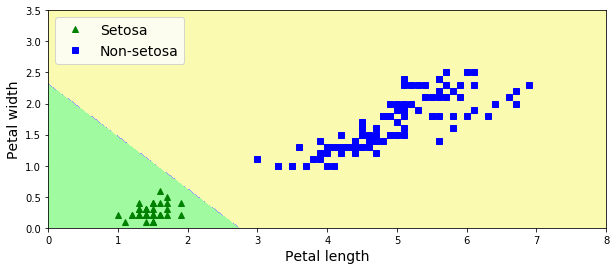

In [29]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

#Load iris
iris = load_iris()
X = iris.data[:,(2,3)] #petal length and width
y = (iris.target==0).astype(np.int) # whether Iris Setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X,y)
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                    np.linspace(0, 3.5, 200).reshape(-1, 1),
                    )
X_new = np.c_[x0.ravel(), x1.ravel()]

# Plot predictions
y_pred = per_clf.predict(X_new).reshape(x0.shape)

fig,ax = plt.subplots(1,figsize=[10,4])
ax.plot(X[y==1, 0], X[y==1, 1], "g^", label="Setosa")
ax.plot(X[y==0, 0], X[y==0, 1], "bs", label="Non-setosa")
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
ax.contourf(x0, x1, y_pred, cmap=custom_cmap, linewidth=5)
ax.set_xlabel("Petal length", fontsize=14)
ax.set_ylabel("Petal width", fontsize=14)
ax.legend(loc="upper left", fontsize=14,frameon=True)

Above we see that the data is linearly separable and the Perceptron works. The Perceptron method strongly resembles Stochastic Gradient Descent, and the class in `sklearn` for `SGDClassifier` is equivalent with the following hyperparameters: `loss="perceptron"`, `learning_rate="constant"`, `eta0=1` (learning rate), and `penalty=None` (no regularization). Unlike Logistic Regression classifiers, Perceptrons do not output a probability and only predict based on hard thresholds.

The limitation of Perceptrons can be eliminated by stacking multiple Perceptrons together into an ANN called a **Multi-Layer Perceptron**.

### Multi-Layer Perceptron and Backpropagation 

<img src='mlp.png'>

An MLP has one (passthrough) input layer, one or more layers of LTUs, called **hidden layers** and one final layer of LTUs called the output layer. Every layer except the output layer includes a bias neuron and is fully connected to the next layer. When an ANN has two or more hidden layers, it is called a deep neural network (DNN). The method for training MLPs is known as backpropagation, which is Gradient Descent using reverse-mode autodiff.

For each training instance, the algorithm feeds it to the network and computes the output of every neuron in each consecutive layer (this is the forward pass just like when making predictions). Then it measures the network's output error (i.e. the difference between the desired output and the actual output of the network) and it computes how much each neuron in the last hidden layer contributed to each output neuron's error. It then proceeds to measure how much of these error contributions came from each neuron in the previous hidden layer, and so on until the algorithm reaches the input layer. The reverse path, measures the gradient across all the connection weights in the network by propagating the error gradient backward in the work. The last step of the backpropagation is a Gradient Descent step on all the connection weights in the network, using the error gradients measured earlier.

In simpler terms, for each training instance the backpropagation algorithm makes a prediction (forward pass), measures the error, and then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally slightly tweaks the connection weights to reduce the error (Gradient Descent step).

In the MLP, the step function is replaced with a logistic function: $\sigma(z) = 1/(1+\exp(-z))$ because the step function contains only flat segments, so there is no gradient to work with. While the logistic function has a well-defined nonzero gradient everywhere. This function is known as the **activation function**. Other backpropagation algorithms can use other activation functions instead of logistic function. Two popular ones are:

* Hyperbolic tangent function: $\tanh(z) = 2\sigma(2z)-1)$, similar to the logistic function it is S-shaped, continuous and differentiable, but the output values range from -1 to 1 instead of 0 to 1, which makes each layer's output more or less normalized about 0 and helps speed up convergence.
* ReLU function: $\max(z,0)$, it is continuous but not differentiable at $z=0$. It works well in practice and has the advantage of being fast to compute.

#### Activation Functions

Below we show the 4 activation functions previously discussed:

Text(0.5,1,'Derivatives')

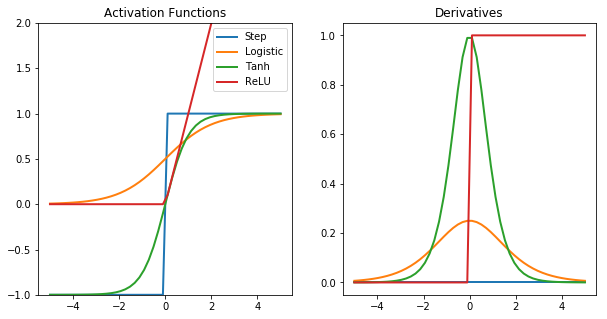

In [17]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

# Plot functions and their derivatives
z = np.linspace(-5,5,50)
fig,(ax1,ax2) = plt.subplots(1,2, figsize=[10,5])
# Step function
ax1.plot(z,np.sign(z),lw=2.0,label='Step')
ax2.plot(z,derivative(np.sign,z),lw=2.0,label='Step')
# Logistic function
ax1.plot(z,logit(z),lw=2.0,label='Logistic')
ax2.plot(z,derivative( logit,z ),lw=2.0,label='Logistic')
# Hyperbolic tan
ax1.plot(z,np.tanh(z),lw=2.0,label='Tanh')
ax2.plot(z,derivative( np.tanh,z ),lw=2.0,label='Tanh')
# ReLU function
ax1.plot(z,relu(z),lw=2.0,label='ReLU')
ax2.plot(z,derivative( relu,z ),lw=2.0,label='ReLU')
ax1.legend();ax1.set_ylim([-1,2])
ax1.set_title('Activation Functions');ax2.set_title('Derivatives')

An MLP is often used for classification with each output corresponding to a different binary class (e.g. spam/ham, urgent/non-urgent). When the classes are exclusive (e.g. 0 through 9) the output layer is typically modified by replacing the individual activation functions by a shared Softmax function, where the output of each neuron corresponds to the estimated probability of the corresponding class.

## 2. Training an MLP with TensorFlow API <a class="anchor" id="mlp"></a>

The easiest way to train an MLP with TensorFlow is to use the high-level API `TF.Learn` which is simialr to `sklearn` API. The `DNNClassifier` makes it easy to train a deep neural network with any number of hidden layers, and a softmax output layer with estimated class probabilities. Here the signal flows only in one direction (from inputs to outputs) so this architecture is an example of a feedforward neural network (FNN).

Below we show example on the MNIST classification data:

In [30]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# get MNIST data
mnist = input_data.read_data_sets("/tmp/data/")
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Below we train a DNN for classification with two hidden layers (one with 300 neurons and one with 100 neurons), and a softmax output layer with 10 neurons.

In [31]:
config = tf.contrib.learn.RunConfig(tf_random_seed=42)
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
#DNN classifier
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100],n_classes=10,
                                        feature_columns=feature_cols,config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
dnn_clf.fit(X_train,y_train,batch_size=50,steps=40000)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1156f1f28>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/9f/fp_4v20s1d16d5v3_z7p0b4h0000gn/T/tmpjjxbrrjc'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer su

INFO:tensorflow:loss = 0.0085514, step = 6801 (0.270 sec)
INFO:tensorflow:global_step/sec: 377.356
INFO:tensorflow:loss = 0.0113093, step = 6901 (0.265 sec)
INFO:tensorflow:global_step/sec: 366.842
INFO:tensorflow:loss = 0.0190613, step = 7001 (0.272 sec)
INFO:tensorflow:global_step/sec: 379.685
INFO:tensorflow:loss = 0.00409009, step = 7101 (0.263 sec)
INFO:tensorflow:global_step/sec: 369.175
INFO:tensorflow:loss = 0.0582136, step = 7201 (0.271 sec)
INFO:tensorflow:global_step/sec: 363.697
INFO:tensorflow:loss = 0.00672715, step = 7301 (0.275 sec)
INFO:tensorflow:global_step/sec: 365.68
INFO:tensorflow:loss = 0.0127499, step = 7401 (0.274 sec)
INFO:tensorflow:global_step/sec: 367.467
INFO:tensorflow:loss = 0.005338, step = 7501 (0.272 sec)
INFO:tensorflow:global_step/sec: 377.495
INFO:tensorflow:loss = 0.0160609, step = 7601 (0.265 sec)
INFO:tensorflow:global_step/sec: 383.051
INFO:tensorflow:loss = 0.00499156, step = 7701 (0.261 sec)
INFO:tensorflow:global_step/sec: 372.424
INFO:tens

INFO:tensorflow:loss = 0.000814515, step = 15001 (0.341 sec)
INFO:tensorflow:global_step/sec: 315.901
INFO:tensorflow:loss = 0.00237104, step = 15101 (0.317 sec)
INFO:tensorflow:global_step/sec: 297.494
INFO:tensorflow:loss = 0.00227502, step = 15201 (0.336 sec)
INFO:tensorflow:global_step/sec: 337.143
INFO:tensorflow:loss = 0.00141252, step = 15301 (0.296 sec)
INFO:tensorflow:global_step/sec: 341.92
INFO:tensorflow:loss = 0.00455337, step = 15401 (0.292 sec)
INFO:tensorflow:global_step/sec: 333.349
INFO:tensorflow:loss = 0.00491852, step = 15501 (0.300 sec)
INFO:tensorflow:global_step/sec: 355.332
INFO:tensorflow:loss = 0.00487903, step = 15601 (0.281 sec)
INFO:tensorflow:global_step/sec: 340.521
INFO:tensorflow:loss = 0.0134273, step = 15701 (0.294 sec)
INFO:tensorflow:global_step/sec: 295.244
INFO:tensorflow:loss = 0.00312125, step = 15801 (0.338 sec)
INFO:tensorflow:global_step/sec: 327.983
INFO:tensorflow:loss = 0.000708232, step = 15901 (0.305 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 391.324
INFO:tensorflow:loss = 0.00224091, step = 23201 (0.256 sec)
INFO:tensorflow:global_step/sec: 397.019
INFO:tensorflow:loss = 0.00193402, step = 23301 (0.252 sec)
INFO:tensorflow:global_step/sec: 393.148
INFO:tensorflow:loss = 0.000599899, step = 23401 (0.254 sec)
INFO:tensorflow:global_step/sec: 387.142
INFO:tensorflow:loss = 0.000690191, step = 23501 (0.258 sec)
INFO:tensorflow:global_step/sec: 385.859
INFO:tensorflow:loss = 0.0006689, step = 23601 (0.259 sec)
INFO:tensorflow:global_step/sec: 387.039
INFO:tensorflow:loss = 0.000450027, step = 23701 (0.258 sec)
INFO:tensorflow:global_step/sec: 395.592
INFO:tensorflow:loss = 0.00181704, step = 23801 (0.253 sec)
INFO:tensorflow:global_step/sec: 391.493
INFO:tensorflow:loss = 0.00110625, step = 23901 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.639
INFO:tensorflow:loss = 0.000971603, step = 24001 (0.257 sec)
INFO:tensorflow:global_step/sec: 386.178
INFO:tensorflow:loss = 0.000599703, step = 2410

INFO:tensorflow:global_step/sec: 315.389
INFO:tensorflow:loss = 0.000428765, step = 31301 (0.317 sec)
INFO:tensorflow:global_step/sec: 347.988
INFO:tensorflow:loss = 0.000609493, step = 31401 (0.287 sec)
INFO:tensorflow:global_step/sec: 351.233
INFO:tensorflow:loss = 0.00025601, step = 31501 (0.285 sec)
INFO:tensorflow:global_step/sec: 340.518
INFO:tensorflow:loss = 8.65842e-05, step = 31601 (0.294 sec)
INFO:tensorflow:global_step/sec: 373.943
INFO:tensorflow:loss = 0.000604256, step = 31701 (0.267 sec)
INFO:tensorflow:global_step/sec: 378.831
INFO:tensorflow:loss = 9.59904e-05, step = 31801 (0.264 sec)
INFO:tensorflow:global_step/sec: 331.314
INFO:tensorflow:loss = 0.00079322, step = 31901 (0.302 sec)
INFO:tensorflow:global_step/sec: 394.611
INFO:tensorflow:loss = 0.000262161, step = 32001 (0.253 sec)
INFO:tensorflow:global_step/sec: 310.686
INFO:tensorflow:loss = 0.000368648, step = 32101 (0.322 sec)
INFO:tensorflow:global_step/sec: 361.869
INFO:tensorflow:loss = 0.00113988, step = 3

INFO:tensorflow:global_step/sec: 368.533
INFO:tensorflow:loss = 0.00066551, step = 39401 (0.271 sec)
INFO:tensorflow:global_step/sec: 343.514
INFO:tensorflow:loss = 0.000248625, step = 39501 (0.291 sec)
INFO:tensorflow:global_step/sec: 346.901
INFO:tensorflow:loss = 0.000750375, step = 39601 (0.288 sec)
INFO:tensorflow:global_step/sec: 358.464
INFO:tensorflow:loss = 0.000224784, step = 39701 (0.279 sec)
INFO:tensorflow:global_step/sec: 366.515
INFO:tensorflow:loss = 0.00105966, step = 39801 (0.273 sec)
INFO:tensorflow:global_step/sec: 359.327
INFO:tensorflow:loss = 0.00136582, step = 39901 (0.278 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /var/folders/9f/fp_4v20s1d16d5v3_z7p0b4h0000gn/T/tmpjjxbrrjc/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00045437.


SKCompat()

In [32]:
from sklearn.metrics import accuracy_score
y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Restoring parameters from /var/folders/9f/fp_4v20s1d16d5v3_z7p0b4h0000gn/T/tmpjjxbrrjc/model.ckpt-40000


0.98240000000000005

We see above that we achieved a score of over 98% on the test set easily! The TF.Learn library provides its own functions to evaluate models:

In [33]:
dnn_clf.score(X_test,y_test)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-11-30-15:16:00
INFO:tensorflow:Restoring parameters from /var/folders/9f/fp_4v20s1d16d5v3_z7p0b4h0000gn/T/tmpjjxbrrjc/model.ckpt-40000
INFO:tensorflow:Finished evaluation at 2017-11-30-15:16:01
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.9824, global_step = 40000, loss = 0.0707704


{'accuracy': 0.9824, 'global_step': 40000, 'loss': 0.070770428}

All of the neuron layers, based on the ReLU activation function (can be changed by setting `activation_fn` hyperparameter) are all under the hood in the `DNNClassifier`. The output layer relies on the softmax function, and the cost function is cross entropy.

## 3. Training a DNN with Plain TensorFlow <a class="anchor" id="dnn"></a>

Here we will use TF's lower level API to have more control over the architecture of the network. We will implement the same model in the last section. The first step is the constructin phase, building the graph. The second is execution, where we will run the graph to train the model.

### Construction Phase

In [44]:
tf.reset_default_graph()

n_inputs = 28*28 # number of pixels
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')

The placeholder `X` will act as the input layer, during the execution phase it will be replaced with one training batch at a time (all instances of the training batch will be processed simultaneously by the neural network). 

Next we will create 2 hidden layers and an output layer. The hidden layers are identical besides the number of neurons contained. The output layer uses a ssoftmax activation function instead of a ReLU activation function. 

In [45]:
def neuron_layer(X,n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs=int(X.get_shape()[1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal( (n_inputs,n_neurons),stddev=stddev)
        W = tf.Variable(init,name='weights')
        b = tf.Variable(tf.zeros([n_neurons]),name='biases')
        z = tf.matmul(X,W)+b
        if activation=='relu':
            return tf.nn.relu(z)
        else:
            return z

Here are the steps we are doing in the code above:
1. Create a name scope using the name of the layer: contains all the computation nodes for the neuron layer.
2. Get the number of inputs by looking at the input matrix shape.
3. The weight matrix, W, contains the weights for each neurons in the layer and each input. It is initialized using a truncated normal distribution with a standard deviation of $2/ \sqrt{n_{inputs}}$ which is known to make convergence faster.
4. Create a variable, b, for biases initialized all to 0. 
5. We create a subgraph to compute the vectorized implementation of  $z = X\cdot W + b$. The weighted sums of the inputs plus the bias term for each and every neuron in the layer, for all instances in the batch in one shot.
6. The activation is set to 'relu' if wanted.

Now let's create the layers:

In [46]:
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X,n_hidden1,"hidden1",activation='relu')
    hidden2 = neuron_layer(hidden1, n_hidden2, 'hidden2',activation='relu')
    logits  = neuron_layer(hidden2,n_outputs,"outputs")
show_graph(tf.get_default_graph())


Note in the above, we use the output of the first hidden layer into the second and so forth. `logits` is the output of the neural network **before** softmax activation. TF actually comes with many handy functions so there is no need to define your own `neuron_layer()` function as there is a built-in `fully_connected()` function that creates a fully connected layer where all the inputs are connected to all the neurons in the layer. It takes care of creating the `weights` and `biases` variables too with the proper initialization strategy, and uses the ReLU activation function by default (this can be changed with the `activation_fn` argument).

Below we'll change the previous code to use the `fully_connected()` function.

In [47]:
from tensorflow.contrib.layers import fully_connected
tf.reset_default_graph()
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
# Neural Network
with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope= "hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope='hidden2')
    logits  = fully_connected(hidden2, n_outputs,scope="outputs",activation_fn=None)
show_graph(tf.get_default_graph())

With the neural network setup, we have to define a cost function that will be used to train it. Just like Softmax Regression we will use cross-entropy, which penalizes models that estimate low probability for the target class.

TF provides functions to compute cross-entropy. Below we will use `sparse_softmax_cross_entropy_with_logits()` that computes cross entropy based on the logits (output of the network before going into softmax activation function), and it expects labels in the form of integers ranging from 0 to `n_outputs -1`. This will give a 1D tensor containing the cross entropy for each instance. We can use TF's `reduce_mean()` function to compute the mean cross entropy over all instances.

> The `sparse_softmax_cross_entropy_with_logits()` function is equivalent to applying softmax activation function and then computing the cross entropy, but is more efficient.

In [48]:
# Loss Function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss  = tf.reduce_mean(xentropy,name='loss')

We have a neural network and now a cost function, and next we need to define a `GradientDescentOptimizer` that will tweak the model parameters to minimize the cost function. We need to define a learning rate first.

In [49]:
# Minimize Cost Function
eta = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(eta)
    training_op = optimizer.minimize(loss)

The last step of the construction phase is to define how to evaluate the model. Here we will simply use accuracy as the performance measure. First for each instance, we determine if the neural network's prediction is correct by checking whether or not the highest logit corresponds to the target class. To do this we can use `in_top_k()` function which returns a 1D tensor full of boolean values, so we need to cast these booleans to floats and compute the average. This will give us the network's overall accuracy. 

In [50]:
# Evaluation
with tf.name_scope('eval'):
    # Find whether the top logit (prediction) is the same as y, returns boolean of instances
    correct = tf.nn.in_top_k(logits,y,1) 
    # Determine accuracy
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

# Initialize all variables and create a SAver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In summary in the construction phase we did the following:
1. Created placeholders for the inputs and targets
2. Created a function to build a neuron layer, and used it to create the DNN
3. Defined the cost function
4. Created the optimizer
5. Defined the performance measure

### Execution Phase

The MNIST data fetched by the TF function scales the data (between 0 and 1) shuffles it, and provides a simple function to load one mini-batch at a time. So we will use it instead.

In [53]:
# Get MNIST data
mnist = input_data.read_data_sets("/tmp/data/")

# Epochs and batch size
n_epochs = 40
batch_size= 50

# Train the model
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size): #integer division
            # Grab batch
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            # Run optimization
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        # Accuracy
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test  = accuracy.eval(feed_dict={X:mnist.test.images,y:mnist.test.labels})
        if epoch % 10 == 0:
            print(epoch,' Train accuracy: ', acc_train, '\t Test accuracy: ', acc_test)
    save_path=saver.save(sess,"./my_model_final.ckpt")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Train accuracy:  0.92 	 Test accuracy:  0.9
Train accuracy:  0.96 	 Test accuracy:  0.9703
Train accuracy:  1.0 	 Test accuracy:  0.9781
Train accuracy:  1.0 	 Test accuracy:  0.9794
Train accuracy:  1.0 	 Test accuracy:  0.9798
Train accuracy:  1.0 	 Test accuracy:  0.9795
Train accuracy:  1.0 	 Test accuracy:  0.9799
Train accuracy:  1.0 	 Test accuracy:  0.9799
Train accuracy:  1.0 	 Test accuracy:  0.98
Train accuracy:  1.0 	 Test accuracy:  0.9801
Train accuracy:  1.0 	 Test accuracy:  0.9801
Train accuracy:  1.0 	 Test accuracy:  0.98
Train accuracy:  1.0 	 Test accuracy:  0.9801
Train accuracy:  1.0 	 Test accuracy:  0.9798
Train accuracy:  1.0 	 Test accuracy:  0.98
Train accuracy:  1.0 	 Test accuracy:  0.9799
Train accuracy:  1.0 	 Test accuracy:  0.9799
Train accuracy:  1.0 	 Test accurac

The code above opens a TF session and runs `init` node that initializes all the variables. Then it runs the main training loop: at each epoch the code iterates through a number of mini-batches that correspond to the training set size. Each mini-batch is fetched via `next_batch()` method, and the code runs the training operation feeding it the current mini-batch input data and targets. At the end of each epoch, the code evaluates the model on the last mini-batch and the full test set. The model parameters are then saved to disk.

### Using the Neural Network for Predictions

With the trained neural network, we can use it to make predictions. We will restore the model, use new scaled images, and evaluate the logits node.

In [56]:
with tf.Session() as sess:
    saver.restore(sess,'./my_model_final.ckpt')
    X_new  = mnist.test.images[:10]
    Z = logits.eval(feed_dict={X:X_new})
    y_pred = np.argmax(Z,axis=1) # highest logit score is predicted class
# Print Results
results = pd.DataFrame(np.c_[mnist.test.labels[:10],y_pred],columns=['True','Predicted'])
results.head(10)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


,True,Predicted
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,5
9,9,9


We see above that the predictions are pretty good for our own neural network construction. Below we'll look at the final graph.

In [57]:
show_graph(tf.get_default_graph())

## 4. Fine-Tuning Neural Network Hyperparameters <a class="anchor" id="hyperparameters"></a>

There are many hyperparameters to tweak in neural networks, which could be seen as their biggest drawback. For example in a simple MLP you can change the number of layers, the number of neurons per layer, type of activation function, the weight initialization logic, and much more. 

We could use grid search with cross-validation to find the right hyperparameters, but there are so many hyperparameters to tune, and since training a neural network on a large dataset takes a lot of time you would only be able to explore a small part of the hyperparameter space in a reasonable time. You could use a random grid search which would be better. It is good to know what values are reasonable for each hyperparameter so you can restrict the search space.

### Number of Hidden Layers

You can always start with a single hidden layer and you will get reasonable results, as MLP with one hidden layer can do a good job with sufficient number of neurons. The advantage of more layers is that fewer neurons are needed than shallow nets making them faster to train. The reason for this is that lower hidden layers model low-level structures (e.g. line segments), intermediate hidden layers combine the low-level structures to model intermediate-level structures (e.g. squares) and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g. faces). The hierarchial architecture helps DNNs converge faster to solution and improves their ability to generalize to new datasets. 

In summary you can start with one or two hidden layers and it will work well (you can get over 97 and 98% on MNIST with 1 and 2 layers with the same number of neurons). For more complex problems, you can ramp up the number of hidden layers until you start overfitting the training set. Very complex tasks require dozens of hidden layers (though not all connected) and need a huge amoutn of training data.

### Number of Neurons per Hidden Layer

The number of neurons in the input and output layers is determined by the type of input and output the task requires. For example, MNIST requires 28x28=784 input neurons and 10 output neurons. Like for the hidden layers, a common practice is to size them to form a funnel with fewer and fewer neurons at each layer - many low-level features coalesce into fewer high-level features. This practice however is not as common now, as you could choose the same size for all hidden layers. 

In general you will see better model improvement by increasing the number of layers than the number of neurons per layer. But finding the perfect number of neurons is not an exact science expect for trial and error. One approach is to pick a model with more layers and more neurons than needed, and use early stopping to prevent it from overfitting (the *dropout* technique is common).

### Activation Functions

In most cases the ReLU activation function can be used in the hidden layers. It is a bit faster to compute than other activation functions, and Gradient Descent does not get stuck as much on plateaus thanks to the fact that it does not saturate for large input values (unlike the logistic or hyperbolic tangent function). For the output layer, the softmax activation function is generally a good choice for classification tasks (when the classes are mutually exclusive). For **regression** tasks you can simply use no activation function at all.

For handling the output layer, if the problem is binary classification, logistic activation function can be used when estimating the probability. If the problem is multiclass, then you must replace the logistic function with the softmax activation function which can handle multiple classes. If you wanted to predict housing prices, then you would need no activation function at all in the output layer.

## 5. Revised Calling Methods <a class="anchor" id="new"></a>

Although above we used `tf.contrib.layers.fully_connected()` for our neural networks, it is now preferable to use `tf.layers.dense()`. They are almost identical except for a couple differences:

* Parameters are renamed, `scope` is `name`, `activation_fn` is `activation`, `weights_initializer` is `kernel_initializer`
* The default `activation` is now `None` instead of `relu`

We will repeat the DNN example with the new methods:

In [60]:
#Construction
tf.reset_default_graph()

n_inputs = 28*28 # number of pixels
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
# Placeholders for training data
X = tf.placeholder(tf.float32, shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64, shape=(None),name='y')
# Neural Network
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X,n_hidden1,name= "hidden1",activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2',activation=tf.nn.relu)
    logits  = tf.layers.dense(hidden2, n_outputs, name="outputs")
# Loss Function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss  = tf.reduce_mean(xentropy,name='loss')
# Minimize Cost Function
eta = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(eta)
    training_op = optimizer.minimize(loss)
# Evaluation
with tf.name_scope('eval'):
    # Find whether the top logit (prediction) is the same as y, returns boolean of instances
    correct = tf.nn.in_top_k(logits,y,1) 
    # Determine accuracy
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# Initialize all variables and create a SAver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Execution
# Epochs and batch size
n_epochs = 40
batch_size= 50
# Train the model
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size): #integer division
            # Grab batch
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            # Run optimization
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        # Accuracy
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test  = accuracy.eval(feed_dict={X:mnist.test.images,y:mnist.test.labels})
        if epoch % 10 == 0:
            print(epoch,' Train accuracy: ', acc_train, '\t Test accuracy: ', acc_test)
    save_path=saver.save(sess,"./my_model_final.ckpt")
show_graph(tf.get_default_graph())

0  Train accuracy:  0.9 	 Test accuracy:  0.8986
10  Train accuracy:  0.98 	 Test accuracy:  0.9586
20  Train accuracy:  0.98 	 Test accuracy:  0.9706
30  Train accuracy:  0.98 	 Test accuracy:  0.9769


## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).